In [1]:
import numpy as np
from scipy.signal import convolve2d
#from kernels import IntensityKernel

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy

INTENSITY = 0

In [2]:
pretend_map = np.zeros((90,90,8))
pretend_map[15,10,0] = 1
pretend_map[25,44,0] = 1
pretend_map[15,34,0] = 1
    
def np_maxpool2D(mat: np.array, pool=3) -> np.array:
    ''' preserves the channels layer '''
    M, N,channels = mat.shape
    K = L = pool
    MK = M // K
    NL = N // L
    return mat[:MK*K, :NL*L].reshape(MK, K, NL, L, channels).max(axis=(1, 3))

def random_action():
    temp = np.random.randint(30,size=6)
    return list(zip(temp[:3], temp[3:]))

In [3]:
def calc_fireside_bonus(obs, actions) -> float:
    # TODO: stitch this into the existing work
    # "obs" is the full state (intensity is extracted in this function)
    # actions is a list of tuples
    
    ''' --- euc distance --- '''
    # calculate euclidean distance (first panel)
    x, y = np.meshgrid(np.linspace(-15, 15, 30),
                       np.linspace(-15, 15, 30))
    pos = np.dstack((x, y))
    # euc distances for all points in mesh
    euc_distance_clipped = np.clip(np.linalg.norm(pos,axis=2)-10,0,20)
    
    ''' --- dilation mask --- '''
    if obs.shape[0] == 90:
        obs = np_maxpool2D(obs,pool=3)

    # why are there negative intensities?
    fires_clipped = np.clip(obs[:,:,INTENSITY],a_min=0,a_max=1) > 0
    dilation_mask = scipy.ndimage.binary_dilation(fires_clipped, iterations=2)

    ''' --- remove "on-fire" --- '''
    fire_removed = dilation_mask.astype(int) - (obs[:,:,INTENSITY] > 0)
    
    ''' --- intersection --- '''
    fireside_available = euc_distance_clipped * fire_removed
    
    ''' --- bonus based on action --- '''
    bonus = 0
    for _x, _y in actions:
        bonus += fireside_available[_x,_y]
    return bonus

In [4]:
pretend_actions = random_action()
pretend_actions[0] = (4,2)

calc_fireside_bonus(obs = pretend_map, actions = pretend_actions)

6.887752811015009

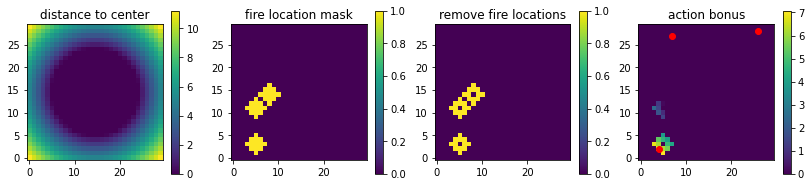

In [5]:
def fireside_vis(obs):
    fig,ax = plt.subplots(1,4,figsize=(14,3))
    
    ''' --- euc distance --- '''
    # calculate euclidean distance (first panel)
    x, y = np.meshgrid(np.linspace(-15, 15, 30),
                       np.linspace(-15, 15, 30))
    pos = np.dstack((x, y))
    # euc distances for all points in mesh
    euc_distance_clipped = np.clip(np.linalg.norm(pos,axis=2)-10,0,20)
    panel = ax[0].imshow(euc_distance_clipped.T,origin='lower')
    plt.colorbar(panel,ax=ax[0])
    ax[0].set_title('distance to center')
    
    ''' --- dilation mask --- '''
    if obs.shape[0] == 90:
        obs = np_maxpool2D(obs,pool=3)
        
    # why are there negative intensities?
    fires_clipped = np.clip(obs[:,:,INTENSITY],a_min=0,a_max=1) > 0
    dilation_mask = scipy.ndimage.binary_dilation(fires_clipped, iterations=2)
    panel = ax[1].imshow(dilation_mask.T,origin='lower')
    plt.colorbar(panel,ax=ax[1])
    ax[1].set_title('fire location mask')
    
    ''' --- remove on-fire --- '''
    fire_removed = dilation_mask.astype(int) - obs[:,:,INTENSITY]
    panel = ax[2].imshow(fire_removed.T,origin='lower')
    plt.colorbar(panel,ax=ax[2])
    ax[2].set_title('remove fire locations')
    
    ''' --- intersection --- '''
    fireside_available = euc_distance_clipped * fire_removed
    panel = ax[3].imshow(fireside_available.T,origin='lower')
    plt.colorbar(panel,ax=ax[3])
    ax[3].set_title('action bonus')
    
fireside_vis(pretend_map)

# visualize location of actions
plt.scatter(*np.array(pretend_actions).T,c='r')